In [10]:
import os
import sys

import matplotlib.pyplot as plt

from keras import Model, Sequential
import numpy as np
from keras.layers import LSTM, Lambda, Reshape, Concatenate
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input

import pickle

# For importing python scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import local files here
from nlp.stocksnlp import Word2Vec
from model.prep_and_train import preprocessing, split_train_test_val
from definitions import root

In [3]:
word2vec = Word2Vec()
price_x, price_y, headline = preprocessing(n_days_forward=7, wv=word2vec)
train, test, val = split_train_test_val(price_y)

In [4]:
# Make sure data is stratified well
print("Train mean:", np.mean(price_y[train]))
print("Test mean:", np.mean(price_y[test]))
print("Validation mean:", np.mean(price_y[val]))

Train mean: 53.873115029387066
Test mean: 53.93124387855045
Validation mean: 53.864759106933015


In [5]:
# Hyperparameters
HIDDEN_SIZE_HEADLINE = 50  # Size of LSTM hidden layer for headline condenser
HIDDEN_SIZE_MAIN = 10  # Size of LSTM hidden layer for main
N_CONDENSED_OUT = 3  # Output feature dimensions for the condenser
N_NUM = 1  # Input feature dimensions of the numerical data (only price for now)
WINDOW_TIME_STEPS = 5  # Number of time steps for each training example
HEADLINE_SEQ_LEN = 9  # Length dim of each headline (e.g. number of words)
N_BATCH = 100  # Training batch size
N_EPOCHS = 15
VAL_SPLIT = 0.33

EMB_SIZE = 300  # Feature size for each embedding. This cannot be modified


# File paths
MODEL_ARCH_PATH = 'model_architecture.json'
MODEL_TRAINED_PATH = 'model_trained.h5'

In [6]:
headline_condenser_g = None


def make_condenser(in_shape, dropout_level=0.3):
    # TODO maybe more outputs?
    condenser = Sequential()
    condenser.add(LSTM(HIDDEN_SIZE_HEADLINE, input_shape=in_shape, activation='relu', name="headline_lstm",
                       dropout=dropout_level))
    condenser.add(Dense(N_CONDENSED_OUT))
    condenser.add(Reshape(target_shape=(1, N_CONDENSED_OUT)))
    # condenser.add(Activation('softmax', name="headline_activation"))
    return condenser


def apply_each(inputs):
    global headline_condenser_g
    outs = list()
    # Split by the time step dimension
    for i in range(inputs.shape[1]):
        outs.append(headline_condenser_g(inputs[:, i, :, :]))

    return Concatenate(axis=1)(outs)

In [7]:
def get_overall_model(headline_len, main_dropout_level=0.4):
    global headline_condenser_g
    headline_in = Input(shape=(WINDOW_TIME_STEPS, headline_len, EMB_SIZE), name="headline_in")
    # Condenser treats each time step of input as separate examples
    headline_condenser_g = make_condenser(in_shape=(headline_len, EMB_SIZE))

    # Apply condenser to each time step of headlines
    headline_out = Lambda(apply_each, name="condense_each_headline")(headline_in)
    # headline_out = TimeDistributed(headline_condenser)(headline_in)
    price_in = Input(shape=(WINDOW_TIME_STEPS, N_NUM), name="price_in")

    # TODO more layers can possibly be added
    x = Concatenate()([headline_out, price_in])  # of shape (WINDOW_SIZE, N_CONCATENATED + N_NUM)
    x = LSTM(units=HIDDEN_SIZE_MAIN, activation="relu", name="main_lstm")(x)  # TODO maybe another LSTM before this?
    x = Dropout(main_dropout_level, name="main_dropout")(x)
    outputs = Dense(1, name="main_dense")(x)

    model = Model(inputs=[headline_in, price_in], outputs=outputs, name="apple_model")
    return model

In [8]:
headline_model = get_overall_model(HEADLINE_SEQ_LEN)
headline_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape', 'cosine'])
history = headline_model.fit(x=[headline[train], price_x[train]], y=price_y[train], epochs=N_EPOCHS,
                    validation_split=VAL_SPLIT)

Train on 1595 samples, validate on 787 samples
Epoch 1/15
1595/1595 [==============================] - 6s 4ms/step - loss: 5182.1434 - mean_absolute_percentage_error: 98.6281 - cosine_proximity: -0.6915 - val_loss: 5089.6127 - val_mean_absolute_percentage_error: 95.6425 - val_cosine_proximity: -1.0000
Epoch 2/15
1595/1595 [==============================] - 1s 866us/step - loss: 4942.8172 - mean_absolute_percentage_error: 88.2596 - cosine_proximity: -0.9549 - val_loss: 4770.4458 - val_mean_absolute_percentage_error: 70.1290 - val_cosine_proximity: -1.0000
Epoch 3/15
1595/1595 [==============================] - 1s 819us/step - loss: 3444.6677 - mean_absolute_percentage_error: 65.3774 - cosine_proximity: -0.9950 - val_loss: 1415.7618 - val_mean_absolute_percentage_error: 42.8299 - val_cosine_proximity: -1.0000
Epoch 4/15
1595/1595 [==============================] - 1s 872us/step - loss: 1795.7366 - mean_absolute_percentage_error: 43.9331 - cosine_proximity: -1.0000 - val_loss: 512.4444 - 

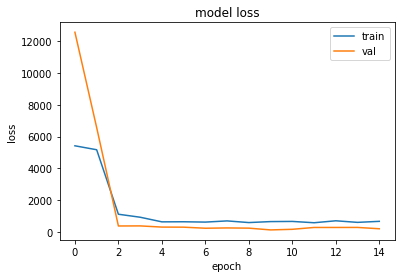

In [8]:
%matplotlib inline
train_to_val = 7 / 3
plt.plot(history.history['loss'])
plt.plot(np.asarray(history.history['val_loss']) * train_to_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Now we train models with the same architecture over multiple datasets, each differing only in n_days_forward, i.e. how far in the future the price_y value is compared to the last x value in each example. As an example, n_days_forward = 1 implies that the prediction date is the next day of the last input value date.

In [48]:
MIN_DAYS = 1
MAX_DAYS = 31
STRIDE = 6
WINDOW = 5  # i.e. no. of input data points per example
N_EPOCHS_MULTI = 10  # Fewer epochs since the graph above indicates that 15 is too many. (Also saves time)
all_hist = dict()
for n_days in range(MIN_DAYS, MAX_DAYS + 1, STRIDE):
    price_x, price_y, headline = preprocessing(n_days_forward=n_days, window=5, wv=word2vec)
    train, test, val = split_train_test_val(price_y)
    model = get_overall_model(HEADLINE_SEQ_LEN)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape', 'cosine'])
    
    print("Training model for n_days_forward = {}...".format(n_days), end='')
    history = headline_model.fit(x=[headline[train], price_x[train]], y=price_y[train], epochs=N_EPOCHS_MULTI,
                    validation_split=VAL_SPLIT, verbose=0)
    print("Done.".format(n_days))
    all_hist[n_days] = history.history
    # Save the model if you wish
print("All models trained.")

Training model for n_days_forward = 1 ...
Model trained.
Training model for n_days_forward = 7 ...
Model trained.
Training model for n_days_forward = 13 ...
Model trained.
Training model for n_days_forward = 19 ...
Model trained.
Training model for n_days_forward = 25 ...
Model trained.
Training model for n_days_forward = 31 ...
Model trained.


In [49]:
with open(root('all_history'), 'wb') as f:
    pickle.dump(all_hist, f)

## Checkpoint
Start here next time.

In [53]:
with open(root('all_history'), 'rb') as f:
    all_hist = pickle.load(f)